In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torchinfo
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import signal

In [2]:
# data_dir = "/Users/trevoryu/Code/syde_599/data/norm_fog_data/"
data_dir = "/root/trevor/syde599/norm_fog_data/"

data_files = glob.glob(data_dir + "*.csv")
len(data_files)

56

# Load the data

In [3]:
WINDOW_SIZE = 650

train_X = []
train_Y = []
test_X = []
test_Y = []

for file in data_files:
    path_parts = file.split('/')
    patient_num = path_parts[-1].split('_')[0]
    
    data = np.loadtxt(file, delimiter=",", skiprows=1)
    # Timestamp is in col 0, labels are in col 1
    # Data is in cols 2 to end
    y = data[:, 1]
    x = data[:, 2:]

    # Remove both waist and right shank columns since test data is missing there
    channels_to_remove = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]  # These are channel inds AFTER removing timestamp and labels
    x = np.delete(x, channels_to_remove, axis=1)


    # Split into non-overlapping windows
    # Don't use the last bit of data that doesn't fill a whole window
    n_windows = y.size // WINDOW_SIZE
    end = WINDOW_SIZE * n_windows
    x = x[:end, :]  # (n_samples, d)
    y = y[:end]

    # Reshape into (n_windows, window_size, d)
    x = x.reshape(n_windows, WINDOW_SIZE, -1)
    y = y.reshape(n_windows, WINDOW_SIZE)
    
    if patient_num in ('001', '005', '007'):
        test_X.append(x)
        test_Y.append(y)
    else:
        train_X.append(x)
        train_Y.append(y)

In [4]:
train_X = np.concatenate(train_X, axis=0)
train_Y = np.concatenate(train_Y, axis=0)

test_X = np.concatenate(test_X, axis=0)
test_Y = np.concatenate(test_Y, axis=0)

# Example of augmentation applied

In [5]:
train_X.shape

(8192, 650, 18)

In [6]:
y = train_X[0, :, 0]

In [7]:
y_stretch = signal.resample(y, int(len(y) * 1.1))
y_squeeze = signal.resample(y, int(len(y) * 0.9))
y_shrink = y * 0.8
y_scaled = y * 1.2

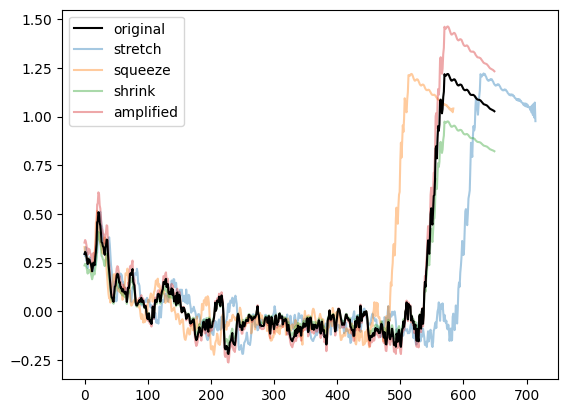

In [8]:
plt.plot(y, label="original", zorder=4, c='k')
plt.plot(y_stretch, label="stretch", alpha=0.4)
plt.plot(y_squeeze, label="squeeze", alpha=0.4)
plt.plot(y_shrink, label="shrink", alpha=0.4)
plt.plot(y_scaled, label="amplified", alpha=0.4)
plt.legend()
plt.show()

In [9]:
# Build dataset, dataloader, collate function

In [10]:
class FoGDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        labels = self.data_y[index, :]
        return inputs, labels


class FoGDataAugment:
    """
    Collate function to apply random time stretch/squeeze and signal shrink/scale
    Apply stretch/squeeze to the time dimension by resampling and truncating to out_samples
        The lower bound of stretch must satisfy (lb * len(input)) > out_samples
    """
    def __init__(self, out_samples=512, p=0.5, stretch=(0.8, 1.2), scale=(0.8, 1.2)):
        """
        Parameters:
        -----------
        p: float between [0, 1], probability of applying each the stretch and scale transform independently
        strech: tuple of float, upper and lower bound on time stretch factor
        scale: tuple of float, upper and lower bound on signal scale factor
        """
        self.p = p
        self.stretch = stretch
        self.scale = scale
        self.out_samples = out_samples
    
    def _reduce_labels(self, y):
        """If there is a 1 in the label, then return 1"""
        return np.any(y == 1, axis=-1).astype(int)

    def _random_crop(self, inputs, labels):
        """Apply a random crop of the signal of length self.out_samples to both inputs and labels"""
        n, d = inputs.shape
        max_offset = n - self.out_samples
        offset = np.random.choice(max_offset)
        inds = slice(offset, offset + self.out_samples)
        return inputs[inds, :], labels[inds]

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (inputs, labels) of length batch_size
            inputs: np.ndarray, dimensions (n_samples, n_channels), signal data
            labels: np.ndarray, dimensions (n_samples,), binary label vector for the signal data

        Returns:
        --------
        (inputs, labels): augmented signal data, reduced labels
        """
        x = []
        y = []
        for (inputs, labels) in data:
            n, d = inputs.shape
            assert (self.stretch[0] * n) >= self.out_samples, f"input size {n} must be greater than {int(self.out_samples / self.stretch[0])} to apply augmentation"

            # Randomly apply time stretch
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.stretch
                stretch = np.random.uniform(lb, ub)
                inputs = signal.resample(inputs, int(n * stretch), axis=0)  # Resample the time (n_samples) axis
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.scale
                scale = np.random.uniform(lb, ub)
                inputs = scale * inputs  # Scale all channels equally
            
            # Apply random crop to self.out_size on both inputs and labels
            inputs, labels = self._random_crop(inputs, labels)

            labels = self._reduce_labels(labels)
            x.append(inputs)
            y.append(labels)
        collated_inputs = torch.tensor(x, dtype=torch.float32)
        collated_labels = torch.tensor(y, dtype=torch.float32)
        return collated_inputs, collated_labels

In [26]:
train_dataset = FoGDataset(train_X, train_Y)
test_dataset = FoGDataset(test_X, test_Y)

augment_fn = FoGDataAugment(out_samples=512)
test_augment = FoGDataAugment(out_samples=512, p=0)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=augment_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=test_augment)

# Define model

In [27]:
class TransformerModel(nn.Module):
    def __init__(self, n_layers=3, in_features=30, d_model=128, n_heads=8, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        self.input_transform = nn.Linear(in_features, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dropout=dropout,
            dim_feedforward=4*d_model,
            activation="gelu",
            batch_first=True,
            norm_first=True)

        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.layer_norm = nn.LayerNorm(d_model)

        # We'll just make a prediction on the features of the first and last sequence point
        self.classifier = nn.Linear(d_model * 2, 1)
    
    def forward(self, x):
        x = self.input_transform(x)
        x = self.encoder(x)
        x = self.layer_norm(x)

        x = x[:, [0, -1], :].reshape(-1, 2 * self.d_model)
        x = self.classifier(x)
        return x

# Training

In [28]:
def train(model, dataloader, optimizer, criterion, epoch, logging_steps=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    total_loss = 0
    correct = 0
    loss_history = []
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss
        loss_history.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct += torch.sum(preds == targets).detach().cpu()

        if i % logging_steps == 0:
            print(f'Epoch: {epoch} ({i}/{len(dataloader)}) Training loss: {loss}')

    accuracy = correct / (dataloader.batch_size * len(dataloader))
    print(f'Epoch {epoch} done. Training loss: {total_loss/len(dataloader)} Training accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader), loss_history

In [29]:
def evaluate(model, dataloader, criterion, epoch, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = criterion(outputs, targets)

            total_loss += loss
            preds = torch.round(torch.sigmoid(outputs))
            correct += torch.sum(preds == targets).detach().cpu()

        accuracy = correct / (dataloader.batch_size * len(dataloader))
        print(f'Epoch {epoch} done. Eval loss: {total_loss/len(dataloader)} Eval accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader)

In [35]:
model = TransformerModel(in_features=18, dropout=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.BCEWithLogitsLoss()
EPOCHS = 5

In [36]:
loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(model, train_loader, optimizer, criterion, epoch)
    eval_acc, eval_loss = evaluate(model, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)
    

1it [00:00,  3.64it/s]

Epoch: 0 (0/128) Training loss: 0.7354116439819336


21it [00:05,  3.86it/s]

Epoch: 0 (20/128) Training loss: 0.6158922910690308


41it [00:10,  3.80it/s]

Epoch: 0 (40/128) Training loss: 0.6007859706878662


61it [00:15,  3.86it/s]

Epoch: 0 (60/128) Training loss: 0.6620466113090515


81it [00:21,  3.84it/s]

Epoch: 0 (80/128) Training loss: 0.5618004202842712


101it [00:26,  3.85it/s]

Epoch: 0 (100/128) Training loss: 0.5165018439292908


121it [00:31,  3.63it/s]

Epoch: 0 (120/128) Training loss: 0.4270697236061096


128it [00:33,  3.83it/s]


Epoch 0 done. Training loss: 0.5510722398757935 Training accuracy: 0.702392578125


21it [00:03,  6.46it/s]


Epoch 0 done. Eval loss: 0.5727185010910034 Eval accuracy: 0.711309552192688


1it [00:00,  3.76it/s]

Epoch: 1 (0/128) Training loss: 0.3870774507522583


21it [00:05,  3.87it/s]

Epoch: 1 (20/128) Training loss: 0.5657519698143005


41it [00:10,  3.86it/s]

Epoch: 1 (40/128) Training loss: 0.3987230658531189


61it [00:15,  3.82it/s]

Epoch: 1 (60/128) Training loss: 0.38709068298339844


81it [00:21,  3.84it/s]

Epoch: 1 (80/128) Training loss: 0.4358374774456024


101it [00:26,  3.85it/s]

Epoch: 1 (100/128) Training loss: 0.34616973996162415


121it [00:31,  3.80it/s]

Epoch: 1 (120/128) Training loss: 0.2300935536623001


128it [00:33,  3.84it/s]


Epoch 1 done. Training loss: 0.3953159749507904 Training accuracy: 0.8209228515625


21it [00:03,  6.49it/s]


Epoch 1 done. Eval loss: 0.6156135201454163 Eval accuracy: 0.71875


1it [00:00,  3.87it/s]

Epoch: 2 (0/128) Training loss: 0.42161595821380615


21it [00:05,  3.86it/s]

Epoch: 2 (20/128) Training loss: 0.3677176833152771


41it [00:10,  3.74it/s]

Epoch: 2 (40/128) Training loss: 0.4438701868057251


61it [00:15,  3.82it/s]

Epoch: 2 (60/128) Training loss: 0.3658446669578552


81it [00:21,  3.84it/s]

Epoch: 2 (80/128) Training loss: 0.40269583463668823


101it [00:26,  3.81it/s]

Epoch: 2 (100/128) Training loss: 0.4150634706020355


121it [00:31,  3.83it/s]

Epoch: 2 (120/128) Training loss: 0.3645782470703125


128it [00:33,  3.83it/s]


Epoch 2 done. Training loss: 0.35952848196029663 Training accuracy: 0.8411865234375


21it [00:03,  6.45it/s]


Epoch 2 done. Eval loss: 0.6165717244148254 Eval accuracy: 0.7291666865348816


1it [00:00,  3.75it/s]

Epoch: 3 (0/128) Training loss: 0.2830955386161804


21it [00:05,  3.85it/s]

Epoch: 3 (20/128) Training loss: 0.37764203548431396


41it [00:10,  3.81it/s]

Epoch: 3 (40/128) Training loss: 0.3964266777038574


61it [00:15,  3.86it/s]

Epoch: 3 (60/128) Training loss: 0.37785857915878296


81it [00:21,  3.82it/s]

Epoch: 3 (80/128) Training loss: 0.2870293855667114


101it [00:26,  3.84it/s]

Epoch: 3 (100/128) Training loss: 0.31260716915130615


121it [00:31,  3.82it/s]

Epoch: 3 (120/128) Training loss: 0.3085750937461853


128it [00:33,  3.83it/s]


Epoch 3 done. Training loss: 0.33247482776641846 Training accuracy: 0.8553466796875


21it [00:03,  6.51it/s]


Epoch 3 done. Eval loss: 0.6044228672981262 Eval accuracy: 0.7522321343421936


1it [00:00,  3.87it/s]

Epoch: 4 (0/128) Training loss: 0.30082273483276367


21it [00:05,  3.82it/s]

Epoch: 4 (20/128) Training loss: 0.3003988265991211


41it [00:16,  2.10it/s]

Epoch: 4 (40/128) Training loss: 0.2641614079475403


61it [00:21,  3.79it/s]

Epoch: 4 (60/128) Training loss: 0.3408684730529785


81it [00:27,  3.82it/s]

Epoch: 4 (80/128) Training loss: 0.3252893388271332


101it [00:32,  3.82it/s]

Epoch: 4 (100/128) Training loss: 0.42403003573417664


121it [00:37,  3.81it/s]

Epoch: 4 (120/128) Training loss: 0.3219392001628876


128it [00:39,  3.25it/s]


Epoch 4 done. Training loss: 0.30995431542396545 Training accuracy: 0.8612060546875


21it [00:03,  6.47it/s]

Epoch 4 done. Eval loss: 0.6688032746315002 Eval accuracy: 0.7120535969734192


In [37]:
import matplotlib.pyplot as plt

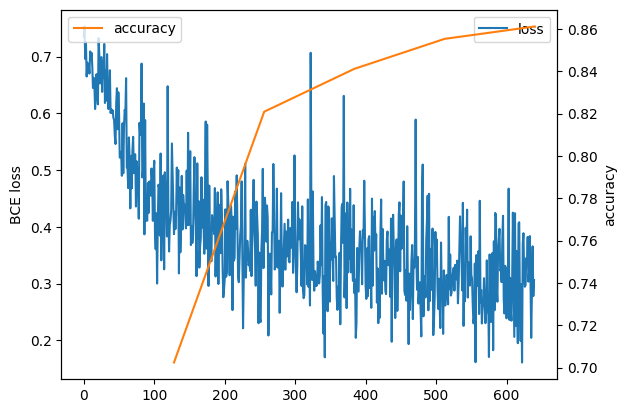

In [38]:
xs = np.arange(len(train_loader), len(loss_history) + len(train_loader), len(train_loader))

plt.plot(loss_history, label="loss")
plt.ylabel("BCE loss")
plt.legend()
plt.twinx()
plt.plot(xs, train_acc_history, label="accuracy", c="C1")
plt.ylabel("accuracy")
plt.legend()
plt.show()

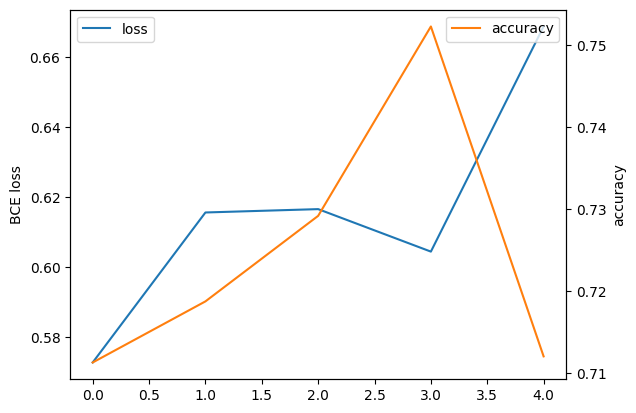

In [39]:
eval_loss_history = [x.cpu() for x in eval_loss_history]
plt.plot(eval_loss_history, label="loss")
plt.legend()
plt.ylabel("BCE loss")
plt.twinx()
plt.plot(eval_acc_history, c="C1", label="accuracy")
plt.ylabel("accuracy")
plt.legend()
plt.show()